### DATA PREPARATION

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/PLN_Timeseries/442100110323_standard_weather_features.csv')
df['READ_DATE'] = pd.to_datetime(df['READ_DATE'])
df.set_index('READ_DATE', inplace=True)
df

,KWH_EXP,Tavg,RH_avg,RR,ss,lag_1,lag_3,lag_7,lag_28,rolling_mean_1,...,season_cos,dayofweek_sin,dayofweek_cos,weekofyear_sin,weekofyear_cos,dayofyear_sin,dayofyear_cos,trend,seasonal,residual
READ_DATE,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,2.334143,25.7,96.0,12.9,7.5,0.000000,0.000000,0.000000,0.000000,2.334143,...,1.0,0.866025,0.5,0.120537,0.992709,0.017166,0.999853,7.684237,-0.017837,-0.000047
2019-01-01 00:15:00,2.344050,25.7,96.0,12.9,7.5,2.334143,0.000000,0.000000,0.000000,2.344050,...,1.0,0.866025,0.5,0.120537,0.992709,0.017166,0.999853,7.684237,-0.011514,-0.000047
2019-01-01 00:30:00,2.500311,25.7,96.0,12.9,7.5,2.344050,0.000000,0.000000,0.000000,2.500311,...,1.0,0.866025,0.5,0.120537,0.992709,0.017166,0.999853,7.684237,0.008583,-0.000047
2019-01-01 00:45:00,2.432096,25.7,96.0,12.9,7.5,2.500311,2.334143,0.000000,0.000000,2.432096,...,1.0,0.866025,0.5,0.120537,0.992709,0.017166,0.999853,7.684237,0.064360,-0.000047
2019-01-01 01:00:00,2.388465,25.7,96.0,12.9,7.5,2.432096,2.344050,0.000000,0.000000,2.388465,...,1.0,0.866025,0.5,0.120537,0.992709,0.017166,0.999853,7.684237,0.045630,-0.000047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31 22:45:00,69.132420,29.8,68.0,0.0,10.8,69.132420,69.132420,65.469139,63.243948,69.132420,...,-1.0,-0.866025,-0.5,0.464723,-0.885456,0.507415,-0.861702,7.684237,-0.035359,-0.000047
2024-05-31 23:00:00,69.132420,29.8,68.0,0.0,10.8,69.132420,69.132420,65.559856,63.452988,69.132420,...,-1.0,-0.866025,-0.5,0.464723,-0.885456,0.507415,-0.861702,7.684237,-0.003232,-0.000047
2024-05-31 23:15:00,68.774401,29.8,68.0,0.0,10.8,69.132420,69.132420,66.302510,63.512601,68.774401,...,-1.0,-0.866025,-0.5,0.464723,-0.885456,0.507415,-0.861702,7.684237,0.030413,-0.000047


In [4]:
# split data train dan test. 3 tahun pertama untuk train, 2 tahun terakhir untuk test
train = df.loc['2019-01-01':'2022-12-31']
test = df.loc['2023-01-01':]

In [5]:
scaler = StandardScaler()

In [6]:
# scaling data train
train_scaled = scaler.fit_transform(train)
train_scaled = pd.DataFrame(train_scaled, columns=train.columns, index=train.index)
train_scaled



,KWH_EXP,Tavg,RH_avg,RR,ss,lag_1,lag_3,lag_7,lag_28,rolling_mean_1,...,season_cos,dayofweek_sin,dayofweek_cos,weekofyear_sin,weekofyear_cos,dayofyear_sin,dayofyear_cos,trend,seasonal,residual
READ_DATE,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,-0.926090,-1.510370,2.072502,0.764111,-0.170246,-1.205025,-1.205015,-1.204993,-1.204902,-0.926090,...,1.189486,1.321971,0.482817,0.170046,1.396816,0.024252,1.418372,-0.297649,-0.595675,-0.000021
2019-01-01 00:15:00,-0.924906,-1.510370,2.072502,0.764111,-0.170246,-0.926085,-1.205015,-1.204993,-1.204902,-0.924906,...,1.189486,1.321971,0.482817,0.170046,1.396816,0.024252,1.418372,-0.297649,-0.384527,-0.000021
2019-01-01 00:30:00,-0.906232,-1.510370,2.072502,0.764111,-0.170246,-0.924901,-1.205015,-1.204993,-1.204902,-0.906232,...,1.189486,1.321971,0.482817,0.170046,1.396816,0.024252,1.418372,-0.297649,0.286599,-0.000021
2019-01-01 00:45:00,-0.914384,-1.510370,2.072502,0.764111,-0.170246,-0.906227,-0.926076,-1.204993,-1.204902,-0.914384,...,1.189486,1.321971,0.482817,0.170046,1.396816,0.024252,1.418372,-0.297649,2.149186,-0.000021
2019-01-01 01:00:00,-0.919598,-1.510370,2.072502,0.764111,-0.170246,-0.914379,-0.924892,-1.204993,-1.204902,-0.919598,...,1.189486,1.321971,0.482817,0.170046,1.396816,0.024252,1.418372,-0.297649,1.523727,-0.000021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 22:45:00,-0.862522,0.644466,0.566106,2.975064,-2.743848,-0.861293,-0.885876,-0.875391,-1.066700,-0.862522,...,1.189486,-1.321971,0.482817,-0.000701,1.407110,-0.024252,1.418372,-0.900381,-0.384527,0.031559
2022-12-31 23:00:00,-0.855322,0.644466,0.566106,2.975064,-2.743848,-0.862517,-0.883604,-0.857880,-1.067552,-0.855322,...,1.189486,-1.321971,0.482817,-0.000701,1.407110,-0.024252,1.418372,-0.899486,0.286599,0.051134
2022-12-31 23:15:00,-0.857181,0.644466,0.566106,2.975064,-2.743848,-0.855318,-0.861283,-0.883256,-1.073320,-0.857181,...,1.189486,-1.321971,0.482817,-0.000701,1.407110,-0.024252,1.418372,-0.898268,2.149186,0.002900


In [7]:
# scaling data test
test_scaled = scaler.transform(test)
test_scaled = pd.DataFrame(test_scaled, columns=test.columns, index=test.index)
test_scaled

,KWH_EXP,Tavg,RH_avg,RR,ss,lag_1,lag_3,lag_7,lag_28,rolling_mean_1,...,season_cos,dayofweek_sin,dayofweek_cos,weekofyear_sin,weekofyear_cos,dayofyear_sin,dayofyear_cos,trend,seasonal,residual
READ_DATE,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,-0.851430,0.082335,0.797859,0.266869,-0.204561,-0.858839,-0.857167,-0.883585,-1.071819,-0.851430,...,1.189486,-4.122367e-16,1.156547,-0.000701,1.407110,0.024252,1.418372,-0.898447,0.082257,0.069148
2023-01-01 00:15:00,-0.845244,0.082335,0.797859,0.266869,-0.204561,-0.851425,-0.878368,-0.861265,-1.073512,-0.845244,...,1.189486,-4.122367e-16,1.156547,-0.000701,1.407110,0.024252,1.418372,-0.898437,-0.055639,0.102322
2023-01-01 00:30:00,-0.848134,0.082335,0.797859,0.266869,-0.204561,-0.845240,-0.858830,-0.862490,-1.076544,-0.848134,...,1.189486,-4.122367e-16,1.156547,-0.000701,1.407110,0.024252,1.418372,-0.898009,0.549754,0.075122
2023-01-01 00:45:00,-0.871030,0.082335,0.797859,0.266869,-0.204561,-0.848129,-0.851416,-0.855290,-1.078695,-0.871030,...,1.189486,-4.122367e-16,1.156547,-0.000701,1.407110,0.024252,1.418372,-0.897633,1.647691,-0.060099
2023-01-01 01:00:00,-0.842770,0.082335,0.797859,0.266869,-0.204561,-0.871026,-0.845231,-0.857149,-1.073512,-0.842770,...,1.189486,-4.122367e-16,1.156547,-0.000701,1.407110,0.024252,1.418372,-0.897749,0.999345,0.092556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31 22:45:00,7.056613,2.330858,-1.172043,-0.381322,0.962138,7.056597,7.056567,6.618735,6.352590,7.056613,...,-0.840700,-1.321971e+00,-0.864643,0.657605,-1.254965,0.716858,-1.216982,-0.297649,-1.180782,-0.000021
2024-05-31 23:00:00,7.056613,2.330858,-1.172043,-0.381322,0.962138,7.056597,7.056567,6.629575,6.377569,7.056613,...,-0.840700,-1.321971e+00,-0.864643,0.657605,-1.254965,0.716858,-1.216982,-0.297649,-0.107940,-0.000021
2024-05-31 23:15:00,7.013828,2.330858,-1.172043,-0.381322,0.962138,7.056597,7.056567,6.718324,6.384693,7.013828,...,-0.840700,-1.321971e+00,-0.864643,0.657605,-1.254965,0.716858,-1.216982,-0.297649,1.015589,-0.000021


In [8]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)


<h4>SPLITTING DATA RATIO :

* Train data : tahun 2019-2022 akhir
* Test data : tahun 2023-ujung data
* Validation data : diambil 10% dari training data. Nantinya parameter `validation_split` di `model.fit` akan melakukan splitting data train

In [9]:
# jika datanya diambil setiap 15 menit, maka time_steps = 96 berarti 24 jam

time_steps = 96
# reshape ke bentuk 3D array
X_train, y_train = create_dataset(train_scaled, train_scaled['KWH_EXP'], time_steps)
X_test, y_test = create_dataset(test_scaled, test_scaled['KWH_EXP'], time_steps)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(140160, 96, 56) (140160,)
(49536, 96, 56) (49536,)


### TRAINING WITH BIDIRECTIONAL-LSTM

In [10]:
model = Sequential()
model.add(Bidirectional(LSTM(units=128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Bidirectional(LSTM(units=64, return_sequences=False)))
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 96, 256)             │         189,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 353,921 (1.35 MB)

 Trainable params: 353,921 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
#  callback
# early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')
# learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

# training
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=512,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 0.0251 - val_loss: 0.0438 - learning_rate: 0.0010
Epoch 2/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0191 - val_loss: 0.0156 - learning_rate: 0.0010
Epoch 3/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.0182 - val_loss: 0.0292 - learning_rate: 0.0010
Epoch 4/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.0240 - val_loss: 0.0635 - learning_rate: 0.0010
Epoch 5/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.0212 - val_loss: 0.0099 - learning_rate: 0.0010
Epoch 6/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.0157 - val_loss: 0.0301 - learning_rate: 9.0484e-04
Epoch 7/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.0241 - val_loss: 0.0095 - learning_rate: 8.1873e-04
Epoch 8/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.0213 - val_loss: 0.0191 - learning_rate: 7.4082e-04
Epoch 9/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.0158 - val_loss: 0.

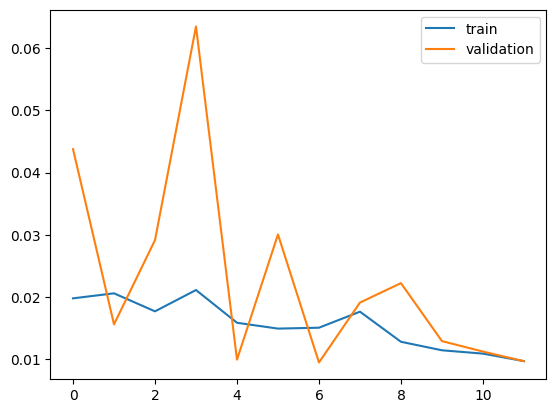

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [16]:
# predict

y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)


1548/1548 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step


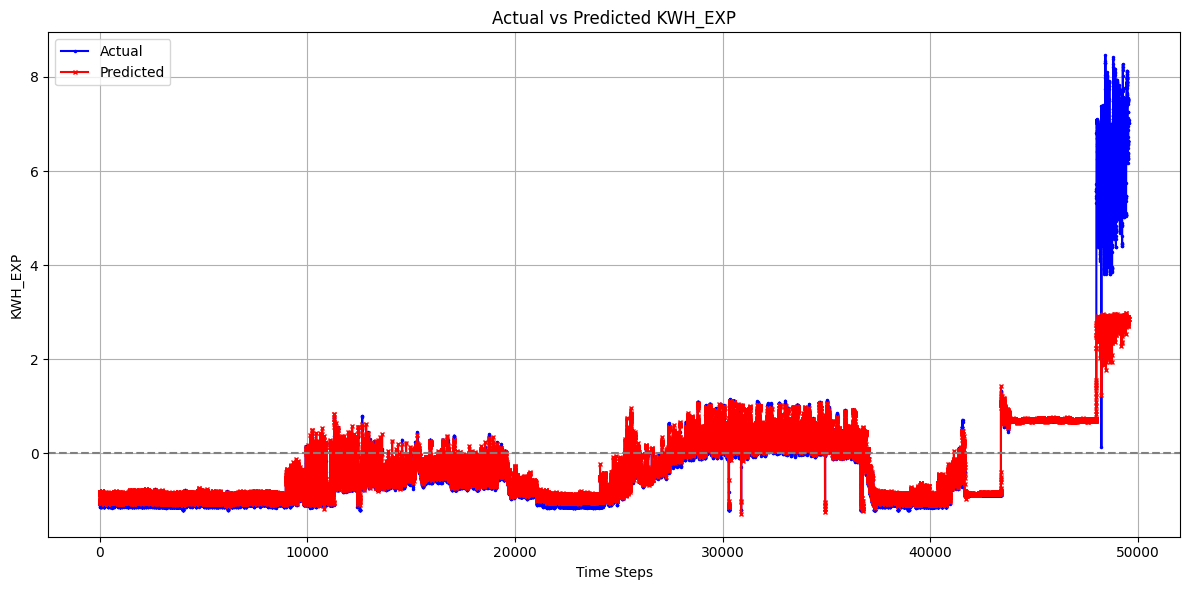

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, marker='.', label='Actual', color='blue', markersize=3)
plt.plot(y_pred, marker='x', label='Predicted', color='red', markersize=3)
plt.axhline(0, color='gray', linestyle='--')  # Garis referensi
plt.title('Actual vs Predicted KWH_EXP')
plt.xlabel('Time Steps')
plt.ylabel('KWH_EXP')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [18]:
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MSE: 0.4339067232387704
MAE: 0.1614328030569165
R2: 0.7586655495469202
MAPE: 0.6458709959707463


### TRAINING WITH LSTM + ATTENTION LAYER

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Layer
import tensorflow as tf

In [20]:
# Define Attention Layer
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def call(self, inputs):
        attention_weights = tf.nn.softmax(tf.matmul(inputs, inputs, transpose_b=True), axis=-1)
        context_vector = tf.matmul(attention_weights, inputs)
        return context_vector

# Model definition with Attention
input_shape = (X_train.shape[1], X_train.shape[2])
inputs = Input(shape=input_shape)
x = LSTM(units=128, return_sequences=True)(inputs)
x = AttentionLayer()(x)
x = LSTM(units=64, return_sequences=False)(x)
outputs = Dense(units=1)(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

# Training the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=512,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stopping, lr_scheduler]
)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 96, 56)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 96, 128)             │          94,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer (AttentionLayer)     │ (None, 96, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 144,193 (563.25 KB)

 Trainable params: 144,193 (563.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.2461 - val_loss: 0.1260 - learning_rate: 0.0010
Epoch 2/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.1108 - val_loss: 0.0907 - learning_rate: 0.0010
Epoch 3/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0914 - val_loss: 0.0467 - learning_rate: 0.0010
Epoch 4/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0646 - val_loss: 0.1045 - learning_rate: 0.0010
Epoch 5/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0482 - val_loss: 0.0544 - learning_rate: 0.0010
Epoch 6/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0341 - val_loss: 0.0566 - learning_rate: 9.0484e-04
Epoch 7/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0316 - val_loss: 0.0881 - learning_rate: 8.1873e-04
Epoch 8/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0309 - val_loss: 0.0249 - learning_rate: 7.4082e-04
Epoch 9/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0283 - val_loss: 0.0211 - le

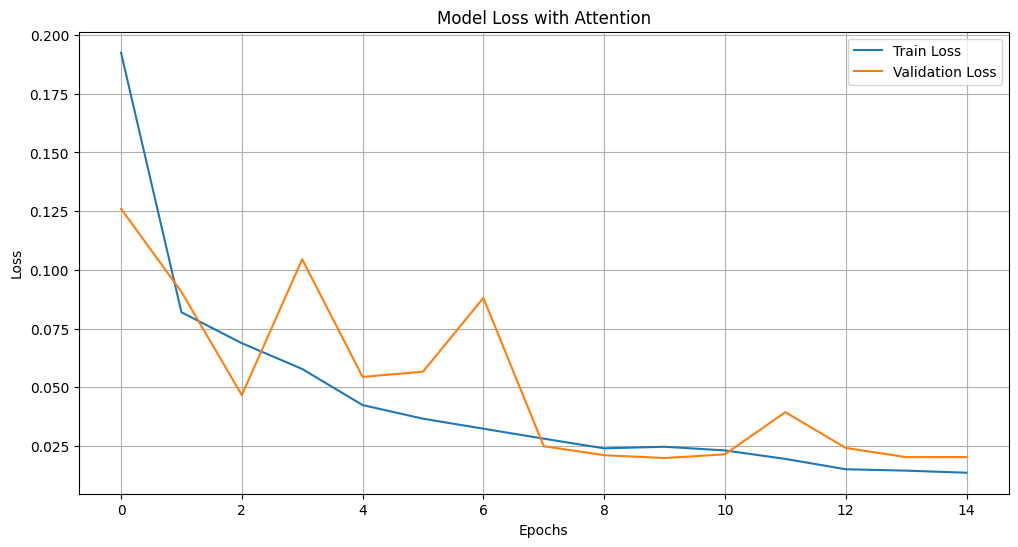

1548/1548 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step


In [21]:
# Plotting the loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with Attention')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Predictions
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

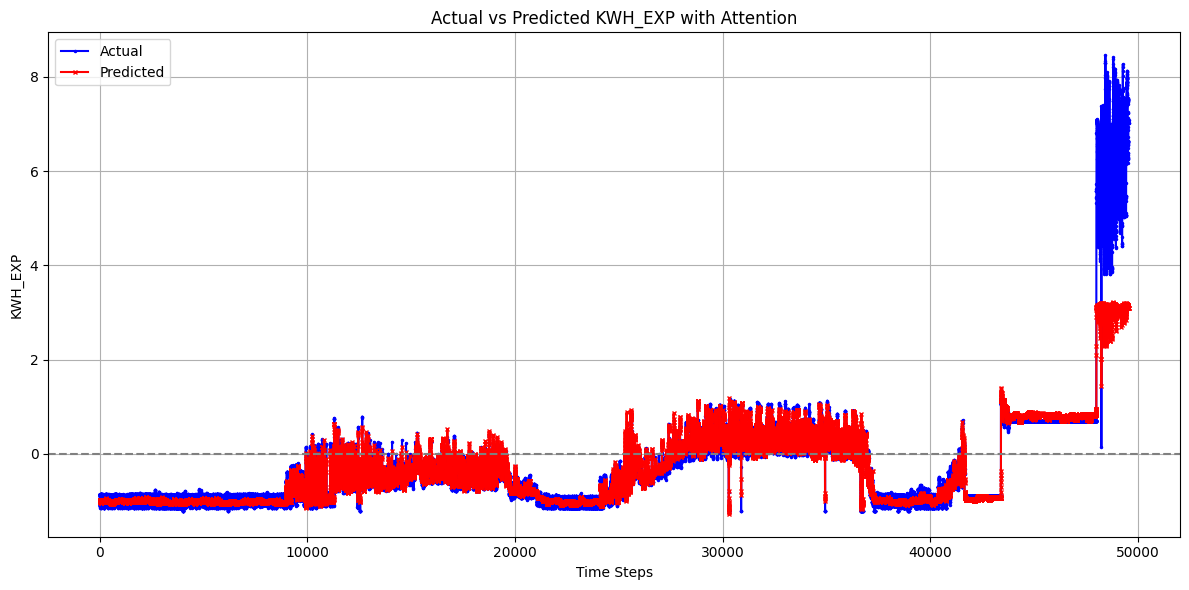

In [22]:
# Actual vs Predicted plot
plt.figure(figsize=(12, 6))
plt.plot(y_test, marker='.', label='Actual', color='blue', markersize=3)
plt.plot(y_pred, marker='x', label='Predicted', color='red', markersize=3)
plt.axhline(0, color='gray', linestyle='--')  # Reference line
plt.title('Actual vs Predicted KWH_EXP with Attention')
plt.xlabel('Time Steps')
plt.ylabel('KWH_EXP')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [23]:
# Metrics
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R²:', r2_score(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MSE: 0.38371090166550553
MAE: 0.19523020999471336
R²: 0.7865839485152595
MAPE: 0.9423260441930191


# TRAINING WITH BIDIRECTIONAL-LSTM + ATTENTION LAYER

In [24]:
# Define Attention Layer
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def call(self, inputs):
        attention_weights = tf.nn.softmax(tf.matmul(inputs, inputs, transpose_b=True), axis=-1)
        context_vector = tf.matmul(attention_weights, inputs)
        return context_vector

# Model definition with Attention
input_shape = (X_train.shape[1], X_train.shape[2])
inputs = Input(shape=input_shape)
x = Bidirectional(LSTM(units=128, return_sequences=True))(inputs)
x = AttentionLayer()(x)
x = Bidirectional(LSTM(units=64, return_sequences=False))(x)
outputs = Dense(units=1)(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

# Training the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=512,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stopping, lr_scheduler]
)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 96, 56)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 96, 256)             │         189,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_1 (AttentionLayer)   │ (None, 96, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 353,921 (1.35 MB)

 Trainable params: 353,921 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - loss: 0.2880 - val_loss: 0.2446 - learning_rate: 0.0010
Epoch 2/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.1285 - val_loss: 0.1937 - learning_rate: 0.0010
Epoch 3/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.1445 - val_loss: 0.0884 - learning_rate: 0.0010
Epoch 4/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.1149 - val_loss: 0.2053 - learning_rate: 0.0010
Epoch 5/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.1182 - val_loss: 0.0464 - learning_rate: 0.0010
Epoch 6/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.0432 - val_loss: 0.0710 - learning_rate: 9.0484e-04
Epoch 7/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.0386 - val_loss: 0.0840 - learning_rate: 8.1873e-04
Epoch 8/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.0371 - val_loss: 0.0943 - learning_rate: 7.4082e-04
Epoch 9/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.0358 - val_loss: 0.

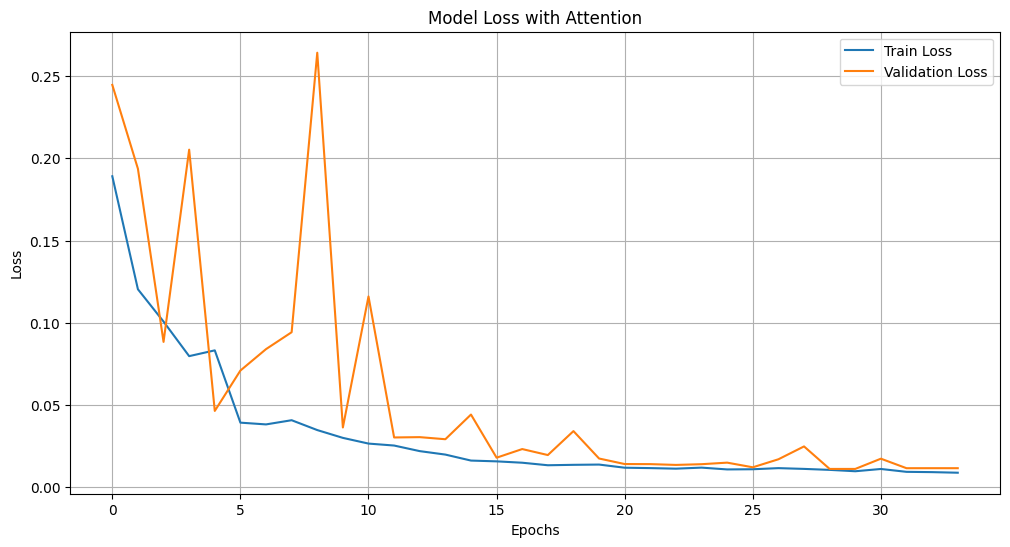

1548/1548 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step


In [25]:
# Plotting the loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with Attention')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Predictions
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

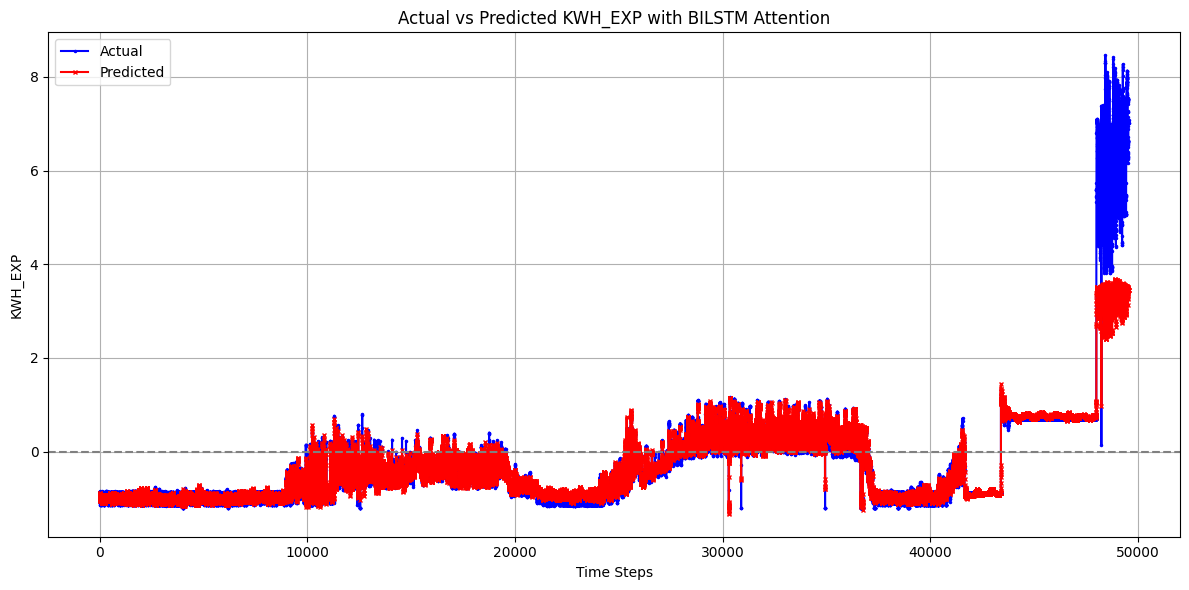

In [26]:
# Actual vs Predicted plot
plt.figure(figsize=(12, 6))
plt.plot(y_test, marker='.', label='Actual', color='blue', markersize=3)
plt.plot(y_pred, marker='x', label='Predicted', color='red', markersize=3)
plt.axhline(0, color='gray', linestyle='--')  # Reference line
plt.title('Actual vs Predicted KWH_EXP with BILSTM Attention')
plt.xlabel('Time Steps')
plt.ylabel('KWH_EXP')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [27]:
# Metrics
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R²:', r2_score(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MSE: 0.31696648491832097
MAE: 0.15930737941923281
R²: 0.8237065056774571
MAPE: 0.6604597050253069


### TRAINING WITH LSTM

In [28]:
model = Sequential()
model.add(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dense(units=1))

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

# Training the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=512,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stopping, lr_scheduler]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 96, 56)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 96, 256)             │         189,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_1 (AttentionLayer)   │ (None, 96, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 353,921 (1.35 MB)

 Trainable params: 353,921 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - loss: 0.0166 - val_loss: 0.0488 - learning_rate: 0.0010
Epoch 2/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.0218 - val_loss: 0.0213 - learning_rate: 0.0010
Epoch 3/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.0297 - val_loss: 0.0268 - learning_rate: 0.0010
Epoch 4/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.0208 - val_loss: 0.0175 - learning_rate: 0.0010
Epoch 5/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.0240 - val_loss: 0.0161 - learning_rate: 0.0010
Epoch 6/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0252 - val_loss: 0.0131 - learning_rate: 9.0484e-04
Epoch 7/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0183 - val_loss: 0.0151 - learning_rate: 8.1873e-04
Epoch 8/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.0194 - val_loss: 0.0219 - learning_rate: 7.4082e-04
Epoch 9/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0186 - val_loss: 0.

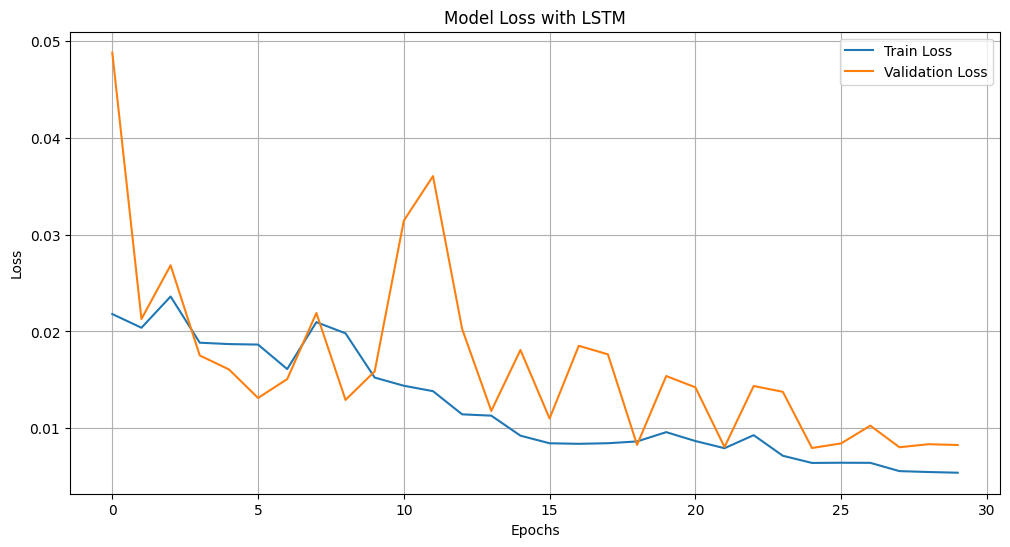

1548/1548 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step


In [29]:
# Plotting the loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Predictions
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

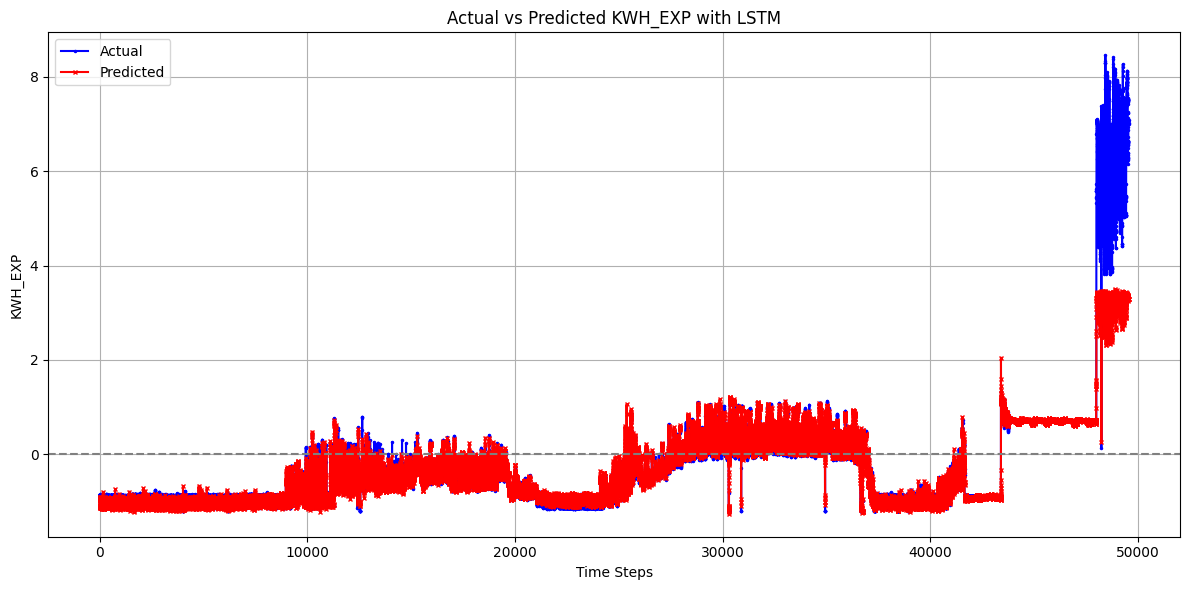

In [30]:
# Actual vs Predicted plot
plt.figure(figsize=(12, 6))
plt.plot(y_test, marker='.', label='Actual', color='blue', markersize=3)
plt.plot(y_pred, marker='x', label='Predicted', color='red', markersize=3)
plt.axhline(0, color='gray', linestyle='--')  # Reference line
plt.title('Actual vs Predicted KWH_EXP with LSTM')
plt.xlabel('Time Steps')
plt.ylabel('KWH_EXP')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [32]:
# Metrics
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R²:', r2_score(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MSE: 0.3400475198082042
MAE: 0.1446172899592808
R²: 0.8108690717942925
MAPE: 0.5388427549077504
